# Homework 1: Reading data and regression
## Due September 5th

In class we've been working on developing the tools for linear regression.  In this homework, we'll use those tools to show that one of the original 'big data' problems can be solved quite credibly with ordinary least squares.  Note that this exercise is primarily intended to do two things: 1) provide you with some practice gathering data, and 2) evaluate your ability to reason somewhat abstractly about models.  With respect to the second point, it is in your grade's interest to provide complete and well-reasoned answers to narrative questions posed.  A correct answer can be awarded very few points if its reasoning is absent or unclear, and an incorrect answer can be awarded full points if it is well argued.   

Please turn in your work via github classroom.

## The big one
If you've ever lived in an area prone to seismic activity, you know that people are always a little apprehensive about *the big one*, that giant earthquake (Magnitude greater than 7) that is going to break the pots and collapse the overpasses.  However, the big one rarely happens... until it does.  What happens more frequently is smaller earthquakes.  And even more frequently than that, even smaller earthquakes.  In fact, it's long been understood that earthquake frequency has an inverse relationship with magnitude.  Here, we're going to quantify that relationship for the west coast of the US.  

## Data wrangling
The first thing that we'll need to do is to aquire a dataset that can help us say something about earthquake frequency.  Fortunately, the United States Geologic Survey keeps such a database.  

First, navigate to https://earthquake.usgs.gov/earthquakes/search/.  This is the USGS' central repository for earthquake data.  We'll be interested in data from the last twenty years.  Enter the appropriate date.  Next, we're interested in data from the west coast of the lower 48.  Use the Custom Geographic Region button on the right side of the page, followed by the Draw Rectangle on the Map button.  Draw a rectangle around the west coast, from the Canadian to Mexican border.  Next, open the Output Options tab and select .csv (comma separated values, a plain text format).  Finally, under Limit Results, enter 19999 (the site will throw an error if you make this value bigger).  This series of commands will deliver the ~20k most recent earthquakes of all sizes to occur in this region of the world.  It may take a moment for their server to pull your query together. Download the file.

Next, import the data into ipython.  This is easily done with [Pandas' read_csv function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html).

In [106]:
# Use pandas to import the earthquake data file here
import pandas as pd
dat = pd.read_csv('./query.csv')

Interrogate the Pandas dataframe for the available fields using its built in method 'keys'


In [107]:
dat.keys()

Index(['time', 'latitude', 'longitude', 'depth', 'mag', 'magType', 'nst',
       'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type',
       'horizontalError', 'depthError', 'magError', 'magNst', 'status',
       'locationSource', 'magSource'],
      dtype='object')

We're primarily interested in determining the relationship between relative frequency and magnitude.  Extract the magnitude variable from the pandas data frame using the 'mag' key.  

Next, you'll need to determine the number of earthquakes that occured in the data as a function of magnitude.  This is easily done by deciding on a set of bins, and then counting the number of items in each bin.  This is also known as a [histogram](https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html), and is easily computed using either numpy or matplotlib.  You'll want to use a fairly large number of bins, say 50 (equally spaced).  *Note that the histogram function provided by either of the above libraries returns total counts rather than relative frequencies: you'll need to compute relative frequencies by dividing the returned counts by the total number of earthquakes in the dataset.*

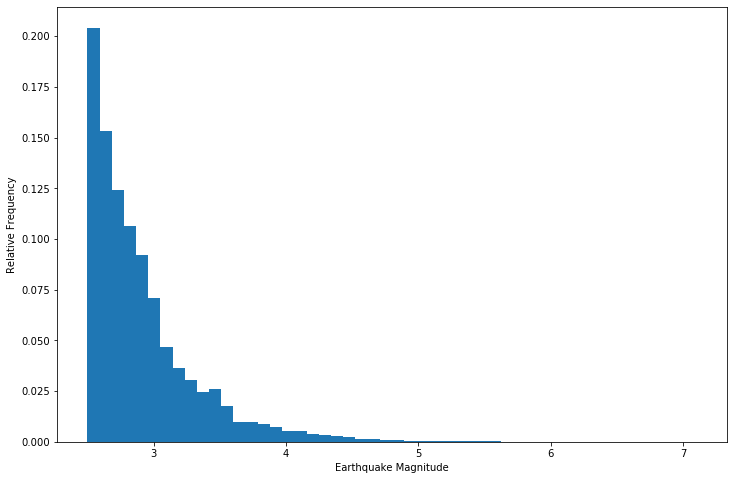

In [108]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [12,8]

mag = dat['mag']

# Weight the histogram to show the relative frequency rather than total count.
plt.hist(mag, 50, weights=np.ones(len(mag))/len(mag))
plt.xlabel('Earthquake Magnitude')
plt.ylabel('Relative Frequency')

plt.show()

**(20 pts) Make a plot with bin centroids on the $x$-axis and relative frequency on the $y$-axis.  Based on your results, please provide a few sentences describing whether the model $y = w_0 + w_1 x$ is a good fit to the data, if $x$ represents earthquake magnitude and $y$ represents relative frequency.**

$y = w_0 + w_1 x$ is not a good fit for these data. The relationship between the magnitude and the relative frequency is clearly nonlinear. As seen in the plot below, the best fit line is not very representative of the observations and either over or underpredicts the frequency. Additionally, the linear model doesn't account for the fact that it is impossible to have a negative frequency. Using the linear model, all estimates of frequency after a magnitude of ~6 are not useful. This is problematic because although they are rare, earthquakes with a magnitude > 6 do occur, and we want our model to capture them. Rather than using a linear model, an exponential decay model where we solve $y = w_0 x^{-w_1}$ for $w_0$ and $w_1$ would likely work much better. 

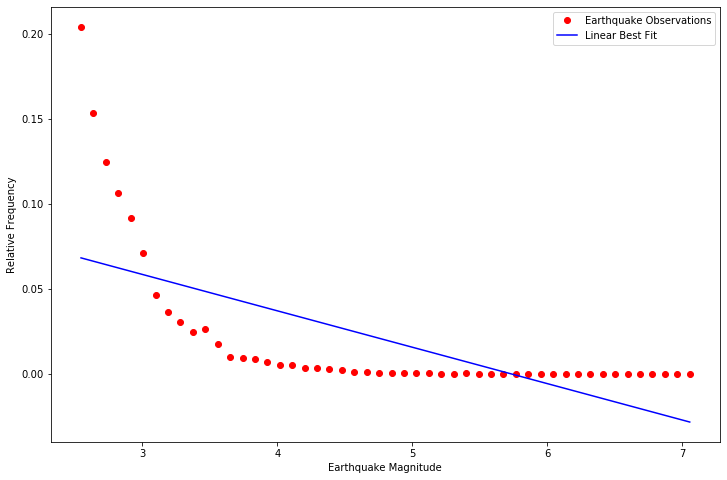

In [109]:
# Split the data into total counts and the bin edges
count, bins = np.histogram(mag, 50)

# Calculate the relative frequenct
freq = count/len(mag)

# Find the centroids of each of the bins
bin_loc = []
for i in range(len(bins)-1):
    bin_loc.append((bins[i] + bins[i+1])/2)

# Function that creates the Vandermonte matrix where x are observations and n is the polynomial order
def make_X(x, n):

    mat = [np.ones(len(x))]
    
    for i in range(1, n+1):
        mat.append(x**i)
    
    return np.matrix(mat).T

# Function to solve for the w vector where x and y are observations and n is the polynomial order.
def solve_w(x, y, n=1):
    
    X = make_X(x, n)
    lhs = np.linalg.inv(np.dot(X.T, X))
    rhs = np.dot(X.T, y)
    
    return (np.dot(lhs, rhs.T)).tolist()

# Solves y = w0 + w1*x 
def calc_y(x, w0, w1):
    
    return w0 + w1*x

def calc_error(m, o):
    
    return sum((m - o) ** 2)

# Find the best fit line for our data
w = solve_w(np.array(bin_loc), np.array(freq))

plt.plot(bin_loc, freq, 'ro', label='Earthquake Observations')
plt.plot(np.array(bin_loc),w[0] + w[1]*np.array(bin_loc),'b-', label='Linear Best Fit')
plt.xlabel('Earthquake Magnitude')
plt.ylabel('Relative Frequency')
plt.legend(loc='upper right')
plt.show()

As it turns out, a physical model that gives the predicted relative frequency of earthquakes of different magnitudes can be derived from physics, and is given by a so-called *power-law*
$$
y = ax^b
$$
**(20pts) If you wanted to directly fit this power-law model to these data, would you be able to use the linear regression code that we've already developed to do so?  If so, how?  If not, why not?**

We could not fit the power-law model to our data using the linear regression code. This is because the linear regression code is defined using the linear function: $y = w_0 + w_1 x$. To find the best fit line to our data, we took the partial derivative of our function with respect to $w_0$ and $w_1$ to find the gradient, which was used to minimize the cost function. The power-law would not work here because it is an entirely different function with a different gradient. We could use the gradient descent method to fit the power-law model to our data, however it would require us to minimize a new cost function where our gradient is derived from the power law:
$$ \frac{\partial I}{\partial a} = - \sum_{i=1}^m (x^b)$$
$$ \frac{\partial I}{\partial b} = - \sum_{i=1}^m (ax^b \ln{x}). $$
If we were to do this, **asodifh**

As it turns out, it is not possible to use linear regression to fit this model directly.  However, it can be done by using a clever transformation of the data.  **(20pts) Plot the base-10 logarithm of the event counts.  Now does a linear model seem like a good fit?  If the power law is a good fit to the untransformed data, why does it make sense that a linear model should fit the log-transformed data (HINT: take the logarithm of both sides of the power law)**

After taking the log of the event counts, the linear model seems to be a much better fit. If the power law is a good fit to the data, it makes sense that a linear model would be a good fit to the log-transformed data. This is beacuse if you take the log of both sides of the power law, you get:
$$
\log_{10}(y) = \log_{10}(a) + b\log_{10}(x)
$$
which is the same format as our linear model: 
$$
y = w_0 + w_1 x
$$
By taking the log of the power function, we are essentially transforming the data from an exponential to a linear relationship. Now, it is possible to just use the linear regression code that we have already developed to solve our system for $a$ and $b$. Additionally, it is important to note that the $\log_{10}(a)$ and $\log_{10}(x)$ on the right hand side of the equation can be treated as though they weren't logged. This is because whether or not we take the log of these variables, the goodness of fit remains the same (as seen in the second plot below). This leaves us with $\log_{10}(y) = a + bx$, exactly matching the initial linear system we solved for. 

/Users/cbandjelly/anaconda/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


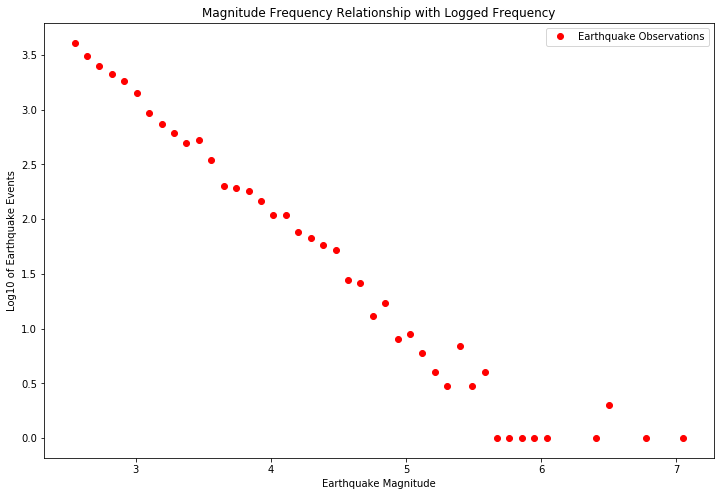

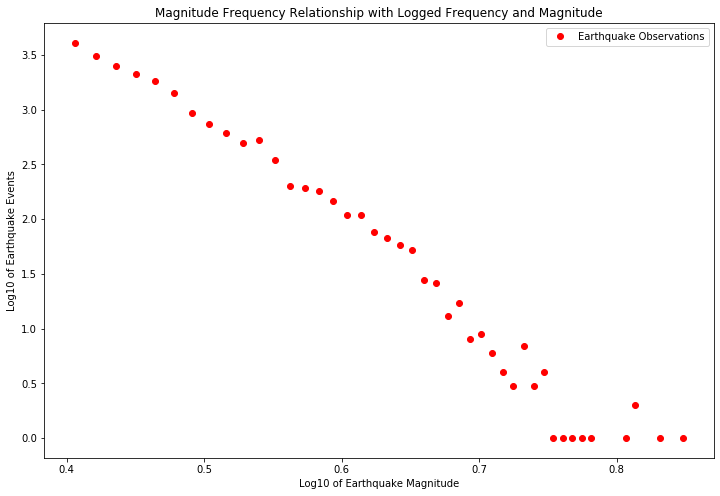

In [110]:
# Take the log of the frequency.
log10 = np.log10(count)

plt.plot(bin_loc, log10, 'ro', label='Earthquake Observations')
plt.xlabel('Earthquake Magnitude')
plt.ylabel('Log10 of Earthquake Events')
plt.legend(loc='upper right')
plt.title('Magnitude Frequency Relationship with Logged Frequency')
plt.show()

# Take the log of earthquake magnitudes as well
plt.plot(np.log10(bin_loc), log10, 'ro', label='Earthquake Observations')
plt.xlabel('Log10 of Earthquake Magnitude')
plt.ylabel('Log10 of Earthquake Events')
plt.legend(loc='upper right')
plt.title('Magnitude Frequency Relationship with Logged Frequency and Magnitude')
plt.show()

Finally, **(40pts) use one of the methods that you developed for linear regression in class to fit a line to the log-transformed counts.  What is the slope of that line?  Is the model a good fit for all sizes of earthquake?**

By solving for $w_0$ and $w_1$, we see that a line fits the log-transformed counts quite nicely. The slope of the fitted line = -0.945, indicating that there is a negative relationship between the log of earthquake frequency and magnitude. However, the fitted line begins to stray further from the data points at magnitudes above ~5.5, suggesting that the model is most accurate for earthquakes with magnitudes between 0 and 5.5. The second graph below shows the best fit line with magnitudes > 5.5 removed. The line indeed fits the data much better than before and also has a lower error (0.300 vs 2.629). However, it is probably not good practice to just scrap data that doesn't fit into our model. To avoid this problem, we would likely either have to use the gradient descent method to minimize the power-law cost function, or set up a piecewise function where our model's slope and intercept changes after a magnitude of 5.5.

/Users/cbandjelly/anaconda/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


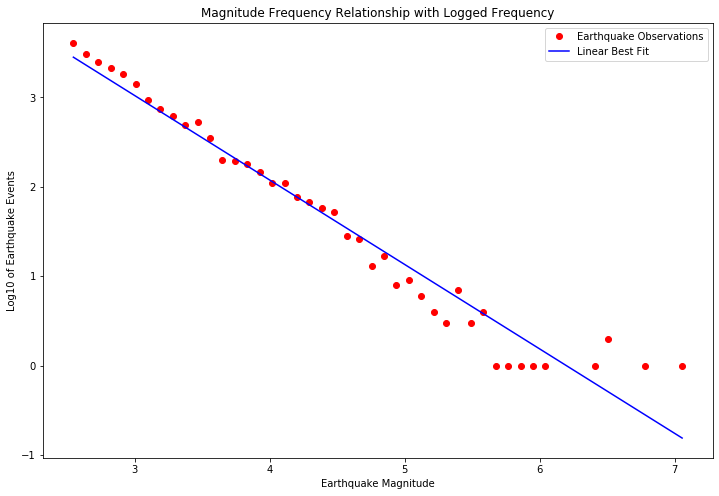

Slope = -0.9449983515583318
Intercept = 5.854815013843755
Error = 2.6289543230946584


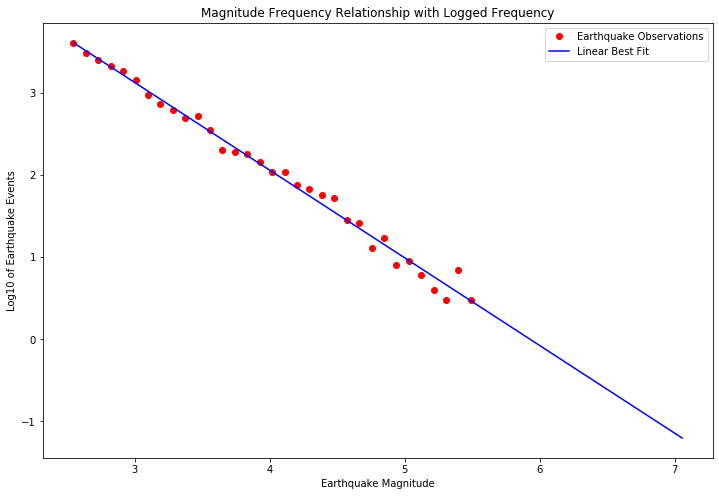

Slope = -1.0679395093831676
Intercept = 6.331157486645367
Error = 0.3001641371645976


In [111]:
from numpy import inf

# get the log10
log10 = np.log10(count)

# remove the infinities created from taking the log of 0
log_bin = np.array(bin_loc)[log10 != -inf]
log10 = log10[log10 != -inf]

# solve for logged frequency
w = solve_w(np.array(log_bin), np.array(log10), 1)
y = calc_y(log_bin, w[0], w[1])
err = calc_error(y, log10)

plt.plot(log_bin, log10, 'ro', label='Earthquake Observations')
plt.plot(np.array(bin_loc),w[0] + w[1]*np.array(bin_loc),'b-', label='Linear Best Fit')
plt.xlabel('Earthquake Magnitude')
plt.ylabel('Log10 of Earthquake Events')
plt.legend(loc='upper right')
plt.title('Magnitude Frequency Relationship with Logged Frequency')
plt.show()

print('Slope = ' + str(w[1][0]))
print('Intercept = ' + str(w[0][0]))
print('Error = ' + str(err))

# Remove earthquakes that have a magnitude greater than 5.5
log10 = log10[np.array(log_bin) < 5.5]
log_bin = np.array(log_bin)[np.array(log_bin) < 5.5]


# solve for logged frequency
w = solve_w(np.array(log_bin), np.array(log10), 1)
y = calc_y(log_bin, w[0], w[1])
err = calc_error(y, log10)

plt.plot(log_bin, log10, 'ro', label='Earthquake Observations')
plt.plot(np.array(bin_loc),w[0] + w[1]*np.array(bin_loc),'b-', label='Linear Best Fit')
plt.xlabel('Earthquake Magnitude')
plt.ylabel('Log10 of Earthquake Events')
plt.legend(loc='upper right')
plt.title('Magnitude Frequency Relationship with Logged Frequency')
plt.show()

print('Slope = ' + str(w[1][0]))
print('Intercept = ' + str(w[0][0]))
print('Error = ' + str(err))
